In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.koopman_regression import KernelRidgeRegression, RandomizedReducedRankRegression, PrincipalComponentRegression, ReducedRankRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern
from DynamicalSystems.utils import plot_eigs
from experiments.common_utils import *
from sklearn.model_selection import TimeSeriesSplit

#### Standardizing dataset

In [2]:
df, standardizing_parameters = split_by_measurement_and_normalize('full_dataframe')

#### Selecting timestep, kernel, desired rank & regularizer

In [133]:
n_timesteps = 3 #In hours
history = 9
average = True
X, Y, features_names = prepare_training_dataset(df, n_timesteps = n_timesteps, history = history, average = average, shift = 0)
#kernel = Linear(coef0=0.)
num_samples = 5000
rank = 10
length_scale = np.float32(np.sqrt(X.shape[1]))
kernel = RBF(length_scale=length_scale)
#kernel = Linear(coef0=0.)

### Cross Validation

In [86]:
tsCV = TimeSeriesSplit(n_splits=2, max_train_size=num_samples)
tikhonov_regs = np.geomspace(1e-7, 1e-1, 20)
estimators = [PrincipalComponentRegression, ReducedRankRegression]
backend = 'cpu'

In [87]:
iterator = tikhonov_regs
error = np.zeros((len(iterator), len(estimators), 2))
for est_idx, estimator in enumerate(estimators):
    for iter_idx, iterate in tqdm.tqdm(enumerate(iterator), desc =estimator.__name__, total=len(iterator)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            if estimator == KernelRidgeRegression:
                model = estimator(kernel, tikhonov_reg = iterate)
            else:
                model = estimator(kernel, rank = rank, tikhonov_reg = iterate)
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, est_idx, 0] = np.mean(_err)
        error[iter_idx, est_idx, 1] = np.std(_err)

ReducedRankRegression: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


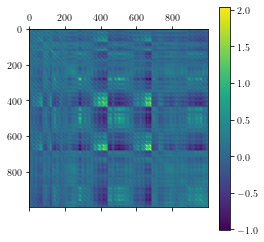

In [88]:
plt.matshow(model.K_X)
plt.colorbar()

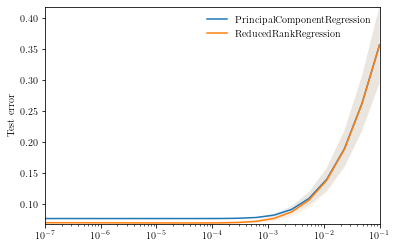

In [89]:
fig, ax = plt.subplots()
for idx, estimator in enumerate(estimators):       
    mean = error[:, idx, 0]
    std = error[:, idx, 1]
    ax.fill_between(iterator, mean - std, mean + std, alpha = 0.1)
    ax.plot(iterator, mean, '-', label = estimator.__name__)
    ax.margins(0)
    ax.legend(frameon=False)
    ax.set_ylabel("Test error") 
ax.set_xscale('log')

### Forecasting

In [134]:
X_train, Y_train = X[:num_samples], Y[:num_samples]
tikhonov_reg = 3e-5 #From CV (see  above)
estimators = [PrincipalComponentRegression, ReducedRankRegression]#, KernelRidgeRegression]
backend = 'keops'

time_offset = 10
idx_0 = num_samples - time_offset
n_steps = 50
ground_truth = Y[idx_0:(idx_0 + n_steps + 1)]

forecasts = []
times = np.arange(1, 10)
fitted_models = []
for estimator in estimators:
    print("Fitting " +estimator.__name__)
    if estimator == KernelRidgeRegression:
        model = estimator(kernel, tikhonov_reg = tikhonov_reg)
    else:
        model = estimator(kernel, rank = rank, tikhonov_reg = tikhonov_reg)
    model.fit(X_train, Y_train, backend = backend)
    model.modes()
    fitted_models.append(model)
    forecasts.append(model.forecast(ground_truth[:-1], times))
ground_truth = ground_truth[1:]

def plot_forecast(ax, t, x, estimator_name, color, style = '-', alpha = 1):
    parsed_data, _ = get_measurement(x, measurement, features_names, history, standardizing_parameters)
    ax.plot(t, parsed_data[:,0], style,color=color, alpha = alpha, label=estimator_name + ' ' + measurement)

Fitting PrincipalComponentRegression
Fitting ReducedRankRegression


In [135]:
measurement = 'DEWP'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
hours = np.linspace(0, n_steps*n_timesteps, n_steps) - n_timesteps*time_offset

forward_errors = np.zeros((len(forecasts), len(times), n_steps))
truth, _ = get_measurement(Y, measurement, features_names, history, standardizing_parameters)
for i in range(len(forecasts)):
    for t_idx, t in enumerate(times):
        predicted, _ = get_measurement(forecasts[i][t_idx], measurement, features_names, history, standardizing_parameters)
        for j in range(n_steps):
            forward_errors[i, t_idx, j] = np.abs(predicted[j] - truth[idx_0 + int(t) + j])

#### 1-step forward forecast Plot

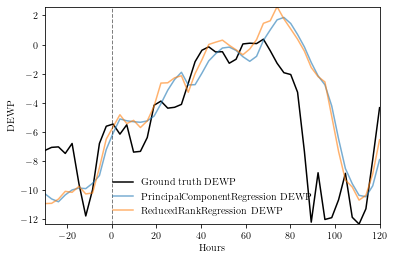

In [136]:
fig, ax = plt.subplots()
plot_forecast(ax, hours, ground_truth, 'Ground truth', 'k', style='-')
shift_idx = 0
for i in range(len(forecasts)):
    plot_forecast(ax, hours + shift_idx, forecasts[i][shift_idx], estimators[i].__name__, cycle[i], alpha = 0.6, style = '-')
ax.axvline(x=0, color='k', linestyle='--', lw=1, alpha = 0.5)
ax.set_ylabel(measurement)
ax.set_xlabel('Hours')
ax.set_xlim(hours[0], hours[-1])
ax.margins(0)
ax.legend(frameon=False)

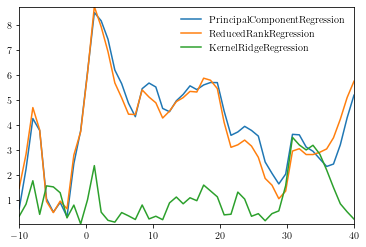

In [19]:
fig, ax = plt.subplots()
for i in range(len(forecasts)):
    ax.plot(hours, forward_errors[i,0,:], '-', color = cycle[i], label = estimators[i].__name__)
plt.legend(frameon=False)
ax.margins(0)

#### n-steps forward forecast error

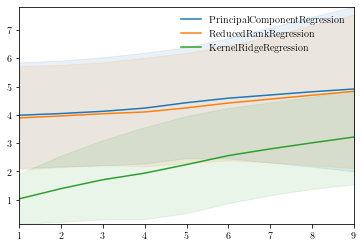

In [20]:
fig, ax = plt.subplots()
for i in range(len(forecasts)):
    mean = forward_errors[i].mean(axis=1)
    std = forward_errors[i].std(axis=1)
    ax.fill_between(times, mean - std, mean + std, alpha = 0.1, color = cycle[i])
    ax.plot(times, mean, '-', color = cycle[i], label = estimators[i].__name__)
plt.legend(frameon=False)
ax.margins(0)
    

### Mode decomposition

In [137]:
estimator_idx = 1
modes = fitted_models[estimator_idx]._modes
evals = fitted_models[estimator_idx]._evals
obs_1 = "PM2.5"
obs_2 = "DEWP"

modes_1, _ = get_measurement(modes, obs_1, features_names, history, None)
modes_2, _ = get_measurement(modes, obs_2, features_names, history, None)
modes_1_avg = modes_1.mean(axis=1)
modes_2_avg = modes_2.mean(axis=1)
c_1 = 'r'
c_2 = 'b'

Text(0.5, 1.0, 'Similar amplitudes suggest similar modes')

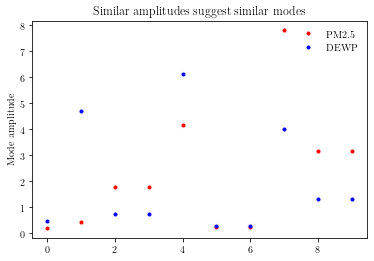

In [138]:
plt.plot(np.abs(modes_1),c_1+'o', alpha=0.02);
plt.plot(np.abs(modes_2),c_2+'o', alpha=0.02);
plt.plot(np.abs(modes_1_avg),c_1+'.', label=obs_1);
plt.plot(np.abs(modes_2_avg),c_2+'.', label=obs_2);
plt.legend(frameon=False)
plt.ylabel("Mode amplitude")
plt.title("Similar amplitudes suggest similar modes")

In [139]:
def causality_rel(idx, eigs, modes_1_avg, modes_2_avg, obs_1, obs_2, stride, n_timesteps, units):
    dphi = np.sign(eigs.imag)*(np.angle(modes_2_avg) - np.angle(modes_1_avg))
    dphi = dphi - np.pi*2*np.floor((dphi + np.pi)/(2*np.pi))
    if np.abs(dphi[idx]) < 1e-12:
        print(f"{obs_1} and {obs_2} are in phase")
    elif np.abs(np.abs(dphi[idx]) - np.pi) < 1e-12:
        print(f"{obs_1} and {obs_2} are anti-phase")
    elif dphi[idx] > 0:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_2} comes first than {obs_1} by {dt} {units}")
    else:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_1} comes first than {obs_2} by {-dt} {units}")
    return dphi

In [141]:
idx = 6
dphi = causality_rel(idx, evals, modes_1_avg, modes_2_avg, obs_1, obs_2, 1, n_timesteps, 'Hours')
print_timescale([evals[idx]], 1, n_timesteps, 'Hours')

DEWP comes first than PM2.5 by 2.03 Hours
Decay: 154.97 Hours  Frequency: 25.16 Hours


Text(0.5, 0, 'Time')

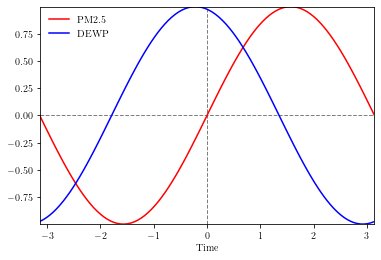

In [23]:
x = np.linspace(-np.pi, np.pi ,100)
phi = dphi[idx]
plt.axvline(x=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.plot(x, np.sin(x), c_1, label=obs_1)
plt.plot(x, np.sin(phi + x), c_2, label=obs_2)
plt.legend(frameon=False)
plt.margins(0)
plt.xlabel("Time")

In [142]:
data_1, feat_1 = get_measurement(X, obs_1, features_names, history, None)
data_2, feat_2 = get_measurement(X, obs_2, features_names, history, None)

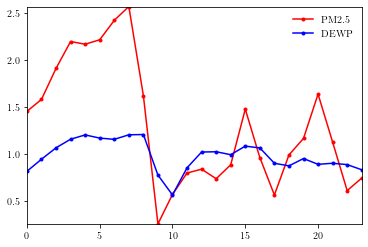

In [196]:
shift = -1
start = 510
delta = 24
plt.plot(data_1[start:start + delta], c_1+'.-', alpha=1, label=obs_1);
plt.plot(data_2[start + shift:start + delta + shift] + 0.3, c_2+'.-', alpha=1, label=obs_2);
plt.legend(frameon=False)
plt.margins(0)